## Overview

Along with a semi-structured JSON file (stored in *data/city_search.json*), the following tasks were provided:  

* There was a bug in the code and one country didn't get logged. It just shows up as an empty field (""). Can you guess which country was that? How?
* For each city, find the most likely city to be also searched for within the same session.
* Travel sites are browsed by two kinds of users. Users who are actually planning a trip and users who just dream about a vacation. The first ones have obviously a much higher purchasing intent. Users planning a trip often search for cities close to each other, while users who search for cities far away from each other are often just dreaming about a vacation. A user searching for LA, SF and Las Vegas in the same session is much more likely to book a hotel than a user searching for NY, Paris, Kuala Lumpur (makes sense, right?). Based on this idea, come up with an algorithm that clusters sessions into two groups: high intent and low intent. Explain all assumptions you make along the way.  

Solutions to these tasks are provided below.

Required libraries are imported below.  A `GOOGLE_API_KEY` environment variable is required for city geocoding.  

In [1]:
%matplotlib inline

import os
import json
import math
import itertools
from collections import defaultdict, Counter

import googlemaps
import matplotlib.pyplot as plt
import seaborn as sns


GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
gmaps = googlemaps.Client(key=GOOGLE_API_KEY)

In [2]:
"""
Some helper functions utilized throughout the solution code.
"""

def distance(lat1, long1, lat2, long2):
    """
    Approximate distance in meters between two lat/long points.
    From John D. Cook: http://www.johndcook.com/blog/python_longitude_latitude
    """
    EARTH_RADIUS = 6371.009  # in kilometers
    degrees_to_radians = math.pi / 180.0     
    phi1 = (90.0 - lat1) * degrees_to_radians
    phi2 = (90.0 - lat2) * degrees_to_radians
    theta1 = long1 * degrees_to_radians
    theta2 = long2 * degrees_to_radians
    cos = (math.sin(phi1) * math.sin(phi2) * math.cos(theta1 - theta2) +
           math.cos(phi1) * math.cos(phi2))
    try:
        arc = math.acos(cos)
    except:
        return 0
 
    return arc * EARTH_RADIUS


# Accessing different attributes of a search
get_cities = lambda x: [str(y).strip().lower() for y in x['cities'][0].split(',')]
get_country = lambda x: x['user'][0][0]['country'].lower()

# Accessing lat/lon from google api results
get_latlon = lambda x: x[0]['geometry']['location']

## Solutions to above questions

In [3]:
with open('data/city_search.json') as f:
    searches = json.load(f)

### Solution 1  

Question: *There was a bug in the code and one country didn't get logged. It just shows up as an empty field (""). Can you guess which country was that? How?*  

Based on the assumption that our best guess will be to find the country of the city with the most searches without a valid country abbreviation.

Based on this assumption, of the top 10 cities searched with a malformed country abbreviation, three are located in Canada (see output below), which is not in the set of unique country codes.

So, we conclude **Canada (CA)** is the missing country.

In [4]:
no_country = defaultdict(lambda: 0)
for search in searches:
    if get_country(search) == '':
        for city in get_cities(search):
            no_country[city] += 1

print(Counter(no_country).most_common(10))

[('new york ny', 754), ('toronto on', 457), ('los angeles ca', 344), ('montreal qc', 334), ('chicago il', 285), ('houston tx', 210), ('vancouver bc', 207), ('philadelphia pa', 145), ('phoenix az', 102), ('san diego ca', 101)]


### Solution 2  

Question: *For each city, find the most likely city to be also searched for within the same session.*  

So we simply have to count the co-occurences of cities across searches, which we can store in dictionary of dictionaries (city -> cocity -> [count across searches]), and can return a tuple with the counts.  Note, we arbitrarily are selecting one city if there is a tie.

In [5]:
cocities = defaultdict(lambda: defaultdict(lambda: 0))
for search in searches:
    cities = get_cities(search)
    for citya, cityb in itertools.product(cities, cities):
        if citya != cityb:
            cocities[citya][cityb] += 1
            cocities[cityb][citya] += 1

max_cooccurence = map(lambda k: (k, Counter(cocities[k]).most_common(1)[0]), cocities)
print(max_cooccurence[:10])  # remove the subset to see all values

[('bakersfield ca', ('los angeles ca', 76)), ('dallas tx', ('plano tx', 164)), ('stockton ca', ('san jose ca', 68)), ('tucson az', ('phoenix az', 36)), ('baltimore md', ('new york ny', 418)), ('kansas city mo', ('minneapolis mn', 2)), ('toronto on', ('new york ny', 840)), ('oakland ca', ('san jose ca', 100)), ('greensboro nc', ('new york ny', 2)), ('omaha ne', ('saint paul mn', 6))]


### Solution 3  

Question: *Travel sites are browsed by two kinds of users. Users who are actually planning a trip and users who just dream about a vacation. The first ones have obviously a much higher purchasing intent. Users planning a trip often search for cities close to each other, while users who search for cities far away from each other are often just dreaming about a vacation. A user searching for LA, SF and Las Vegas in the same session is much more likely to book a hotel than a user searching for NY, Paris, Kuala Lumpur (makes sense, right?). Based on this idea, come up with an algorithm that clusters sessions into two groups: high intent and low intent. Explain all assumptions you make along the way.*  

Here, we are provided the fact that a distance metric will model relationship between a search and a booking, but we have no way, via the data, to validate this relationship.  Thus, we hope that there will be a somewhat obvious heuristic for classifying the searches via some distance metric (i.e. bimodal pattern).

To do this, we must:

1. Geocode the unique cities, so that we can compute the distance between them.  
2. Calculate a weighted distance metric based on distances between search cities.  
3. Inspect the distribution for our distance metric, and find a cut-off value for classifying into 'high' or 'low' intent. 

In [7]:
# First, let's get the unique cities in our dataset, and geocode their locations
# We'll use a generator that we can iterate over

def unique_cities():
    seen = []
    for search in searches:
        for city in get_cities(search):
            if city not in seen:
                seen.append(city)
                yield city

In [8]:
# Next we'll use Google's geocoding api to get the location of each unique city
# The response we'll be storing is a dict with 'lat' and 'lon' keys

locations = {}
for city in unique_cities():
    locations[city] = get_latlon(gmaps.geocode(city))

In [9]:
search_distances = []
for search in searches:
    cities = get_cities(search)
    if len(cities) == 1:
        search_distances.append((0.0, 1))
        continue
    pairwise_sum = 0
    count = 0
    for citya, cityb in itertools.product(cities, cities):
        if citya != cityb:
            coordsa = locations[citya]
            coordsb = locations[cityb]
            pairwise_sum += distance(coordsa['lat'], coordsa['lng'], coordsb['lat'], coordsb['lng'])
            count += 1
    search_distances.append((pairwise_sum, count))

#### Assumptions about search distances  

* There is a well-defined cost function associated with labelling/mislabelling vacationers vs. dreamers.  
* Searches with more than 10 cities are dreamers.
* Searches with one city are considered to be valid (though likely should be related to user's country of origin).
* We will ignore a user's historical queries, going only off information in the current search.

Using these assumptions, we will simply say that a search with a mean pairwise distance between cities of **less than 500 km** is a high-intent browser.

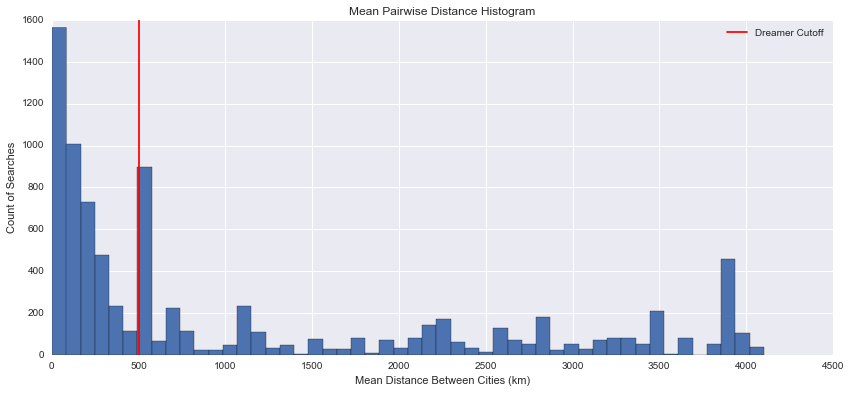

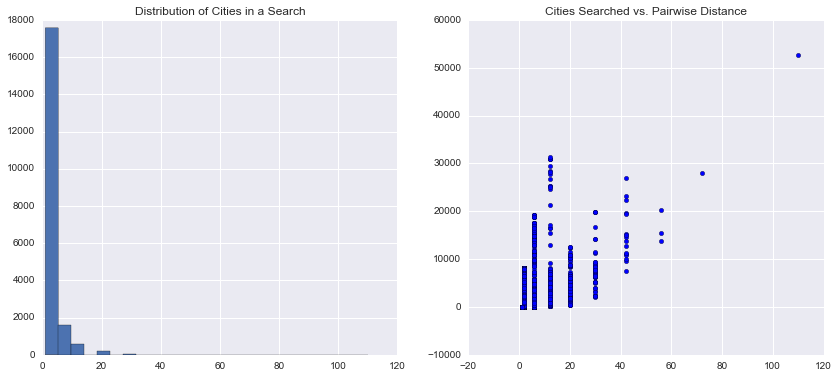

In [11]:
plt.figure(figsize=(14, 6))
plt.hist([x[0] / x[1] for x in search_distances if x[1] <= 10 and x[1] > 1], 50)
plt.axvline(500, label='Dreamer Cutoff', color='r')
plt.legend(loc='upper right')
plt.title('Mean Pairwise Distance Histogram')
plt.xlabel('Mean Distance Between Cities (km)')
plt.ylabel('Count of Searches')
plt.show()

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.hist([x[1] for x in search_distances], 25)
plt.title('Distribution of Cities in a Search')
plt.subplot(122)
plt.title('Cities Searched vs. Pairwise Distance')
plt.scatter([x[1] for x in search_distances], [x[0] for x in search_distances])
plt.show()